# TCC - Helder Rezende

# Apresentação TCC

In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas.io.data as web
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import scipy
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.4/dist-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


https://risk-engineering.org/VaR/

http://www.analyticsresearch.net/Documents/2013AFEsession5.Practicals.pdf

financephd.typepad.com/files/copulas.pdf

http://www.impa.br/opencms/pt/ensino/downloads/mestrado_profissional_projeto_fim_curso/projetos_fim_cursos_2013/Cristiane_Azevedo.pdf


http://epub.lib.aalto.fi/fi/ethesis/pdf/12049/hse_ethesis_12049.pdf

### Introdução

O objetivo do trabalho primeiramente é analisar os modelos de VAR e volatilidade na crise brasileira. Primeiramente iremos listar os retornos do indice bovespa durante o periodo 1/1/2015 até a data atual.

In [151]:
cotacoes_bovespa_calc = web.DataReader('^BVSP', data_source='yahoo', start='1/1/2014', end = '3/20/2015')['Close']
len(web.DataReader('^BVSP', data_source='yahoo', start='1/1/2014', end = '3/20/2015')['Close'])

314

In [148]:
cotacoes_bovespa = web.DataReader('^BVSP', data_source='yahoo', start='3/21/2015', end = '4/1/2016')['Close'] # cotacoes atraves do yahoo finace
retornos_bovespa_abs = abs(np.log(cotacoes_bovespa / cotacoes_bovespa.shift(1))).dropna() 
retornos_bovespa = (np.log(cotacoes_bovespa / cotacoes_bovespa.shift(1))).dropna() 
pd.DataFrame(retornos_bovespa.sort_values()[-5:]*100) # ordena os valores e pega os 5 maiores

,Close
Date,
2016-02-22,3.992132
2016-01-29,4.494911
2015-11-03,4.653587
2016-03-03,4.996370
2016-03-17,6.388665


Percebe-se que na data 2016-03-17 teve um retorno extramamente alto. Nesse dia teve a decisao do impeachment

https://www.youtube.com/watch?v=2QJykxUNb6I

Testando se os retornos do Indice bovespa segue uma distribuicao normal

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


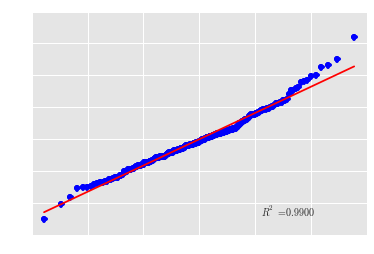

In [111]:
Q = retornos_bovespa.as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Microsoft daily returns in 2013", weight="bold");

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


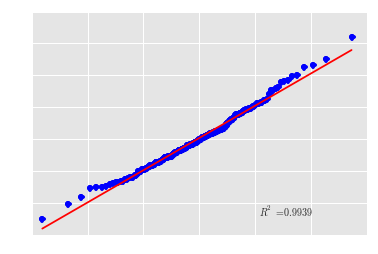

In [112]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Microsoft daily returns in 2013", weight="bold");

#### 1-1 Carteira de ações

Montando uma carteira de ações de acordo com o site http://www.infomoney.com.br/onde-investir/acoes/noticia/5495117/btg-pactual-recomenda-acoes-para-investir-com-novo-governo

In [113]:
acoes = ['PETR4', 'ITUB4','BVMF3', 'GGBR4']
pesos = [0.25,0.25,0.25,0.25]
pd.DataFrame([acoes,pesos] , index = ['Ação', 'Peso']).transpose()

,Ação,Peso
0,PETR4,0.25
1,ITUB4,0.25
2,BVMF3,0.25
3,GGBR4,0.25


In [114]:
cotacoes_carteira_ativos = pd.DataFrame()
for x in acoes:
    cotacoes_carteira_ativos[x] = web.DataReader(x+'.SA', data_source='yahoo', start='1/1/2015')['Close']

cotacoes_carteira_ativos.head(15) # mostra as 15 primeiras cotacoes

,PETR4,ITUB4,BVMF3,GGBR4
Date,,,,
2015-01-02,9.36,37.21307,9.50,9.11
2015-01-05,8.61,37.40001,9.22,8.72
2015-01-06,8.33,38.00501,9.31,9.69
2015-01-07,8.67,39.37993,9.71,10.42
2015-01-08,9.18,39.99607,9.61,10.22
2015-01-09,9.40,38.24701,9.40,9.66
2015-01-12,8.91,37.32294,9.06,9.43
2015-01-13,9.00,37.27901,9.10,9.10
2015-01-14,8.74,37.53202,9.17,8.70


In [115]:
retornos_carteira_ativos = np.log(cotacoes_carteira_ativos / cotacoes_carteira_ativos.shift(1)).dropna()
retornos_carteira_ativos.head(10)*100 # mostra os 10 primeiros retornos

,PETR4,ITUB4,BVMF3,GGBR4
Date,,,,
2015-01-05,-8.352097,0.501093,-2.991676,-4.375347
2015-01-06,-3.306086,1.604702,0.971405,10.547519
2015-01-07,4.000533,3.553830,4.206719,7.263261
2015-01-08,5.715841,1.552490,-1.035206,-1.938045
2015-01-09,2.368248,-4.471581,-2.209453,-5.635294
2015-01-12,-5.353545,-2.445724,-3.684057,-2.409755
2015-01-13,1.005034,-0.117772,0.440529,-3.562168
2015-01-14,-2.931439,0.676400,0.766287,-4.495139
2015-01-15,6.639606,-0.883379,0.760460,2.497292


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


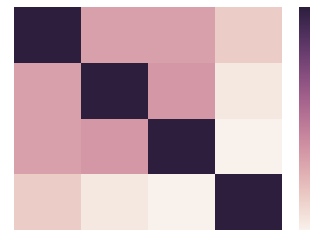

In [116]:
corr = retornos_carteira_ativos.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [117]:
retornos_carteira = (retornos_carteira_ativos*(25)).sum(axis = 1)
retornos_carteira

Date
2015-01-05   -3.804507
2015-01-06    2.454385
2015-01-07    4.756086
2015-01-08    1.073770
2015-01-09   -2.487020
2015-01-12   -3.473270
2015-01-13   -0.558594
2015-01-14   -1.495973
2015-01-15    2.253495
2015-01-16    2.598610
2015-01-19   -4.226656
2015-01-20    1.428989
2015-01-21    2.994748
2015-01-22    1.950948
2015-01-23   -1.314644
2015-01-26   -0.212297
2015-01-27    0.352849
2015-01-28   -3.949226
2015-01-29   -0.248717
2015-01-30   -3.234163
2015-02-02    3.175761
2015-02-03    5.887853
2015-02-04    1.053585
2015-02-05   -1.204583
2015-02-06   -1.861484
2015-02-09    1.635025
2015-02-10   -2.830486
2015-02-11   -0.882917
2015-02-12    1.984494
2015-02-13    3.222893
                ...   
2016-10-14   -0.762510
2016-10-17    1.912921
2016-10-18   -0.010588
2016-10-19    0.752017
2016-10-20    0.944007
2016-10-21    1.235324
2016-10-24    0.094188
2016-10-25   -0.877643
2016-10-26    0.524951
2016-10-27    0.793661
2016-10-28    0.560987
2016-10-31    1.082863
2016-1

### BackTesting - Configuração

Cenários de Backtestings:

In [118]:
pd.DataFrame({"Data Inicial" : ['3/21/2015',' 3/25/2014','4/5/2012'],"Data Final" : '4/1/2016'} , index = [255,510,1000])

,Data Final,Data Inicial
255,4/1/2016,3/21/2015
510,4/1/2016,3/25/2014
1000,4/1/2016,4/5/2012


#### Kupiec Tests 

Tabela de Não-Rejeição de acordo o numero de falhas N.

In [119]:
Kupiec = pd.DataFrame(index = [0.01,0.025,0.05,0.075,0.01])

In [120]:
Kupiec["VaR"] = ["99%"," 97.5","95%", "92.5%","90%"]
Kupiec["T = 255 dias"] = ["N<7", "2<N<12", "6<N<21", "11<N<28", "16<N<36"]
Kupiec["T = 510 dias"] = ["1<N<11", "6<N<21", "16<N<36", "27<N<51", "38<N<65"]
Kupiec["T = 1000 dias"] = ["4<N<17", "15<N<36", "37<N<65", "59<N<92", "81<N<120"]

In [121]:
Kupiec

,VaR,T = 255 dias,T = 510 dias,T = 1000 dias
0.010,99%,N<7,1<N<11,4<N<17
0.025,97.5,2<N<12,6<N<21,15<N<36
0.050,95%,6<N<21,16<N<36,37<N<65
0.075,92.5%,11<N<28,27<N<51,59<N<92
0.010,90%,16<N<36,38<N<65,81<N<120


### 1 - VaR histórico

In [23]:
cotacoes = web.DataReader('^BVSP', data_source='yahoo', start='2015/01/01', end = '2016/03/16')['Close']

In [24]:
retornos = np.log(cotacoes / cotacoes.shift(1)).dropna()
confianca = 0.95

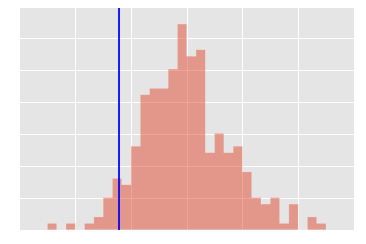

In [25]:
retornos.hist(bins=30,normed=True,histtype='stepfilled',alpha=0.5)

plt.axvline(x=retornos.quantile([1-confianca,confianca])[1-confianca], color='b')

In [26]:
def var_historico(retornos, confianca):
    
    return retornos.quantile([1-confianca,confianca])[1-confianca]
        

In [27]:
var_99_historico = var_historico(retornos, 0.99)
var_95_historico = var_historico(retornos, 0.95)
var_90_historico = var_historico(retornos, 0.90)

cvar_99_historico=[]
cvar_95_historico=[]
cvar_90_historico=[]

for x in retornos:
    if x <var_99_historico:
        cvar_99_historico.append(x)
    if x <var_95_historico:
        cvar_95_historico.append(x)
    if x <var_90_historico:
        cvar_90_historico.append(x)

    
var_historico = pd.DataFrame(index =[0.90,0.95,0.99])
var_historico['VaR(%)'] = [var_90_historico*100,var_95_historico*100,var_99_historico*100]
var_historico['CVaR(%)'] = [np.mean(cvar_90_historico)*100,np.mean(cvar_95_historico)*100,np.mean(cvar_99_historico)*100]
var_historico

,VaR(%),CVaR(%)
0.90,-1.844418,-2.582684
0.95,-2.422788,-3.053313
0.99,-3.090246,-4.230869


In [144]:
retornos[:10]

Date
2015-01-05   -0.020724
2015-01-06    0.010134
2015-01-07    0.030003
2015-01-08    0.009657
2015-01-09   -0.022333
2015-01-12   -0.014436
2015-01-13   -0.002038
2015-01-14   -0.008277
2015-01-15    0.007944
2015-01-16    0.020425
Name: Close, dtype: float64

### 1.2 BackTest

### 2 - VaR paramétrico

#### 2.1 - Calculando a volatilidade histórica

In [129]:
volatilidade_valores = []

volatilidade_valores = pd.rolling_std(retornos,60)*100*sqrt(252)
volatilidade_valores = volatilidade_valores.dropna()


volatilidade = pd.DataFrame(volatilidade_valores, index = retornos.index,columns = ["Index IBOVESPA"])

/usr/local/lib/python3.4/dist-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


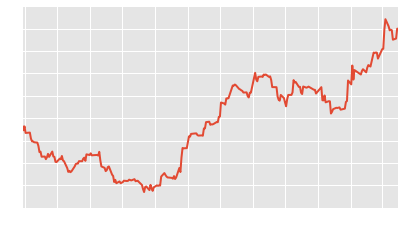

In [130]:
volatilidade_valores.plot()

#### 2.1.1 - VaR

In [131]:
var_parametrico = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])

In [132]:
var_parametrico['VAR(%)'] = (volatilidade_valores[-1]/sqrt(252)) * var_parametrico


In [133]:
var_parametrico

,Alpha,VAR(%)
0.90,1.28,2.579490
0.95,1.65,3.325124
0.99,2.23,4.493956


#### 2.2 - Calculando a volatidade usando EWMA

/usr/local/lib/python3.4/dist-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


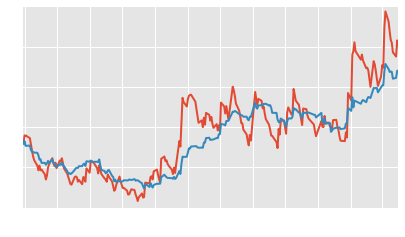

In [134]:
variance = (retornos)**2
ewma_variance = pd.ewma(variance, span = 30)[60:]
volatilidade_valores_ewma = pd.DataFrame([ewma_variance]).apply(sqrt)*100*sqrt(252)


volatilidade_valores_ewma.plot()
volatilidade_valores.plot()

#### 2.2.1 - VaR

In [135]:
var_parametrico_ewma = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])

In [136]:
var_parametrico_ewma['VAR(%)'] = (volatilidade_valores_ewma[-1]/sqrt(252)) * var_parametrico_ewma

In [137]:
var_parametrico_ewma

,Alpha,VAR(%)
0.90,1.28,2.822454
0.95,1.65,3.638320
0.99,2.23,4.917244


#### 2.3 - Calculando a volatidade usando GARCH(1,1)

In [138]:
am = arch_model(retornos)
res = am.fit(update_freq=5)
volatilidade_valores_garch = res.conditional_volatility[60:]*100*sqrt(252)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -818.448650223
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


/usr/local/lib/python3.4/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/usr/local/lib/python3.4/dist-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


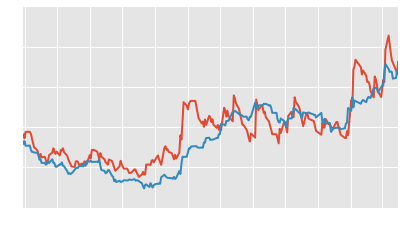

In [139]:
volatilidade_valores_garch.plot()
volatilidade_valores.plot()

#### 2.3.1 - VaR

In [140]:
var_parametrico_garch = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])
var_parametrico_garch['VAR(%)'] = (volatilidade_valores_garch[-1]/sqrt(252)) * var_parametrico_garch
var_parametrico_garch

,Alpha,VAR(%)
0.90,1.28,2.679264
0.95,1.65,3.453739
0.99,2.23,4.667780


### 3 - VaR Monte Carlo

In [124]:
days = 2   
dt = 1/float(days)
sigma = 0.04 
mu = 0.05  
startprice = cotacoes[-1]

In [125]:
def random_walk(startprice):
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

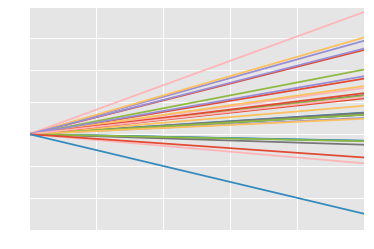

In [126]:
for run in range(30):
    plt.plot(random_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price");

#### 3.1 - VaR

In [127]:
runs = 10000
simulations = []
for run in range(runs):
    simulations.append(random_walk(startprice)[days-1])
simulations = pd.DataFrame([simulations]).transpose()

In [128]:
var_99_montecarlo = simulations.quantile([0.01,0.99])[0][0.01]
var_95_montecarlo = simulations.quantile([0.05,0.95])[0][0.05]
var_90_montecarlo = simulations.quantile([0.1,0.9])[0][0.1]

### Using Extreme Value Theory and Copulas to Evaluate Market Risk

<img src="image.JPG">



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


In [11]:
iniditalDate = "1/1/2014"
ativos = ['ABEV3', 'PETR4','RADL3','BBDC4']

In [12]:
cotacoesAmbev = web.DataReader('ABEV3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesRadl = web.DataReader('RADL3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start=iniditalDate)['Close']


In [13]:
cotacoes = [cotacoesAmbev,cotacoesPetr,cotacoesRadl,cotacoesBbdc]
cotacoesPandas = pd.DataFrame(index = ativos, data = cotacoes)


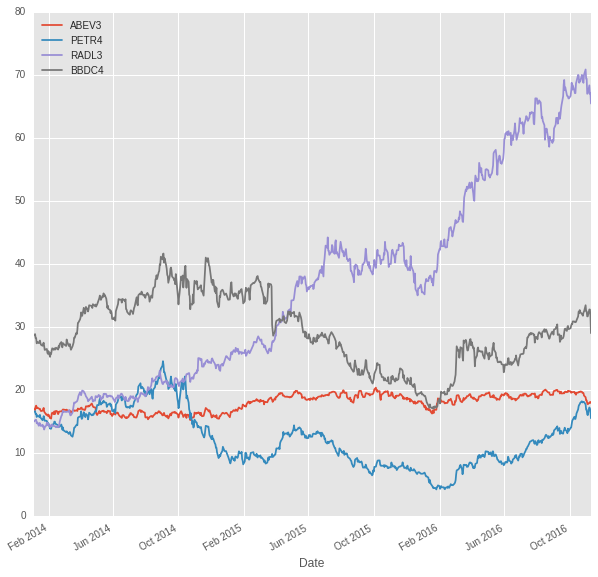

In [14]:
cotacoesPandas.transpose().dropna().plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

In [15]:
def logReturn(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

In [16]:
returns = [logReturn(cotacoes[x]) for x in range(len(cotacoes))]
returnsPandas = pd.DataFrame(index = ativos, data = returns)
returnsPandas = returnsPandas.transpose().dropna()

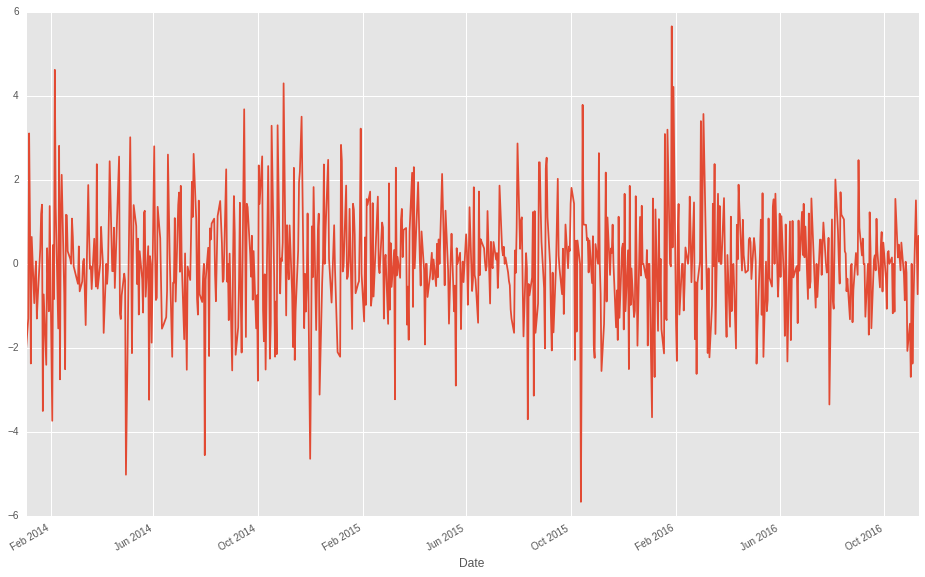

In [41]:
(returnsPandas["ABEV3"]*100).plot(figsize=(16,10))

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3
https://pypi.python.org/pypi/arch/3.0#bootstrap

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

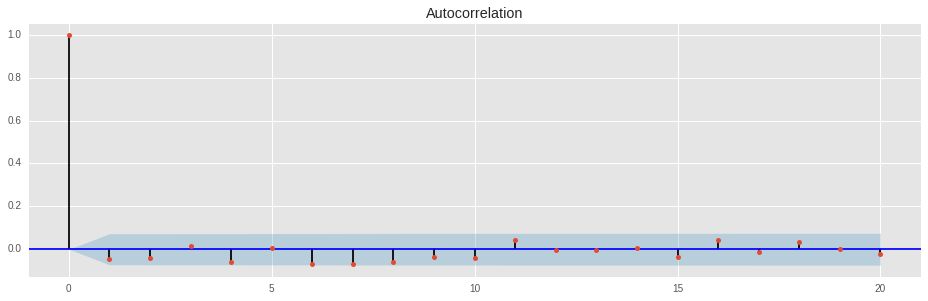

In [18]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"], lags=20, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

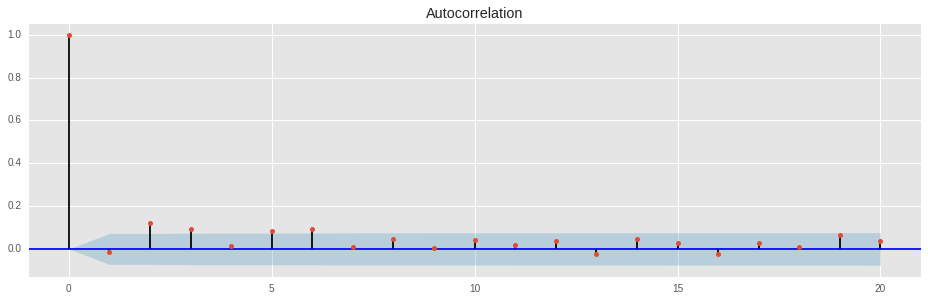

In [19]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"]**2, lags=20, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} + \psi[\epsilon_{t-1}<0]\epsilon^2_{t-1}$$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. In particular, the last term incorporates asymmetry (leverage) into the variance by a Boolean indicator that takes the value 1 if the prior model residual is negative and 0 otherwise (see Glosten, Jagannathan, & Runkle [3]).

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.

Pacote python utilizado http://arch.readthedocs.io/en/latest/univariate/introduction.html

In [32]:
am = arch.arch_model(returnsPandas["ABEV3"]*100, mean='AR', vol='GARCH', dist = 'StudentsT' )
res = am.fit()


Iteration:      1,   Func. Count:      7,   Neg. LLF: 1236.06417152
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1236.00267489
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1235.99457344
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1235.92355692
Iteration:      5,   Func. Count:     45,   Neg. LLF: 1235.69721144
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1235.67660593
Iteration:      7,   Func. Count:     61,   Neg. LLF: 1235.57940627
Iteration:      8,   Func. Count:     68,   Neg. LLF: 1235.50701167
Iteration:      9,   Func. Count:     75,   Neg. LLF: 1235.48611183
Iteration:     10,   Func. Count:     82,   Neg. LLF: 1235.48296894
Iteration:     11,   Func. Count:     89,   Neg. LLF: 1235.4828462
Iteration:     12,   Func. Count:     96,   Neg. LLF: 1235.48283522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1235.48283522
            Iterations: 12
            Function evaluations: 96
            Grad

In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                        ABEV3   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -1235.48
Distribution:      Standardized Student's t   AIC:                           2480.97
Method:                  Maximum Likelihood   BIC:                           2503.92
                                              No. Observations:                  728
Date:                      Fri, Nov 11 2016   Df Residuals:                      723
Time:                              10:28:28   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0188  4.437e-02      0.423      0.672    [-6.819e-02,  0.106]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          0.0293  2.954e-02      0.993      0.321  [-2.855e-02,8.724e-02]
alpha[1]       0.0469  1.996e-02      2.349  1.880e-02   [7.772e-03,8.600e-02]
beta[1]        0.9383  2.870e-02     32.690 2.137e-234       [  0.882,  0.995]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             6.5506      1.589      4.122  3.764e-05       [  3.435,  9.666]
==============================================================================

Covariance estimator: robust
"""

In [38]:
pd.DataFrame([res.resid,returnsPandas["ABEV3"]*100]).transpose().head(10)

,resid,ABEV3
Date,,
2014-01-03,-2.169591,-2.150821
2014-01-06,-1.319322,-1.300551
2014-01-07,3.086948,3.105718
2014-01-08,0.957497,0.976267
2014-01-09,-2.389728,-2.370958
2014-01-10,0.622878,0.641649
2014-01-13,-0.953444,-0.934674
2014-01-14,-0.312656,-0.293886
2014-01-15,0.040076,0.058846


For the selected index, compare the model residuals and the corresponding conditional standard deviations filtered from the raw returns. The lower graph clearly illustrates the variation in volatility (heteroskedasticity) present in the filtered residuals.

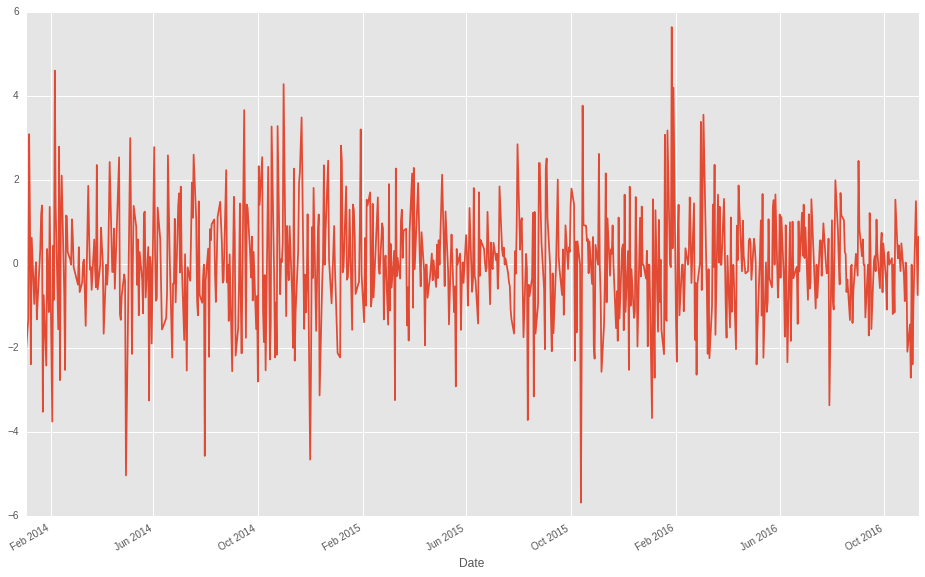

In [42]:
res.resid.plot(figsize=(16,10))

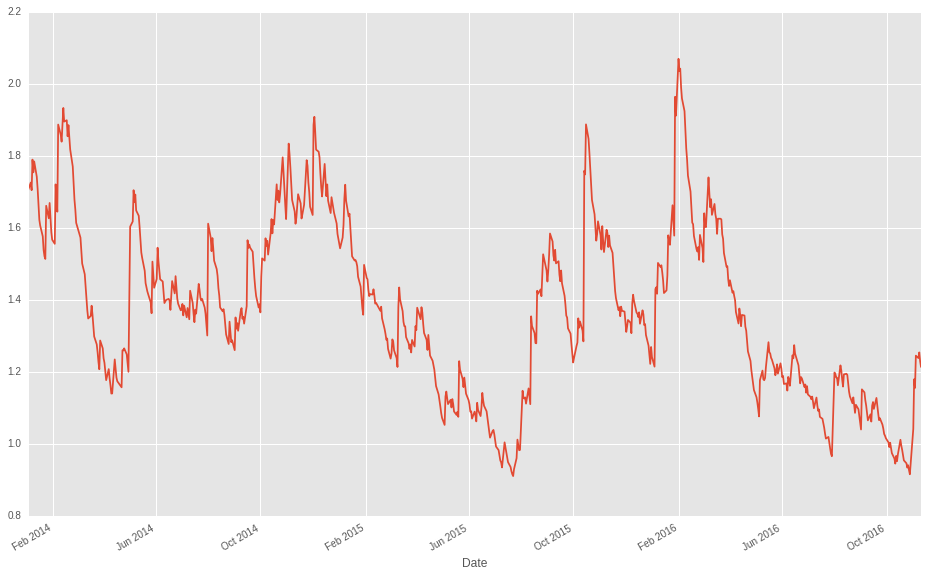

In [44]:
res.conditional_volatility.plot(figsize=(16,10))

Having filtered the model residuals from each return series, standardize the residuals by the corresponding conditional standard deviation. These standardized residuals represent the underlying zero-mean, unit-variance, i.i.d. series upon which the EVT estimation of the sample CDF tails is based.

In [45]:
resid = res.resid/res.conditional_volatility

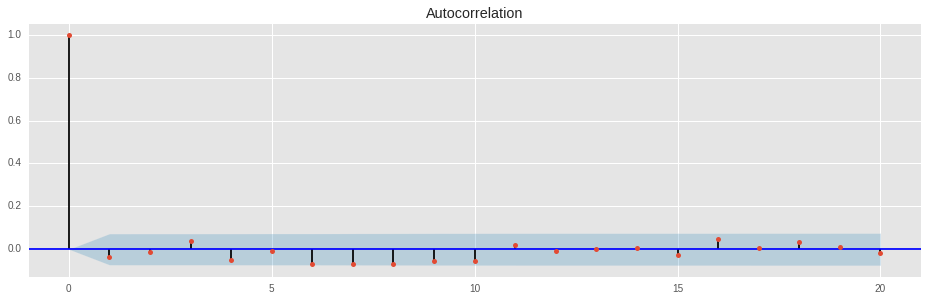

In [49]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax1)

Estimate the Semi-Parametric CDFs

Given the standardized, i.i.d. residuals from the previous step, estimate the empirical CDF of each index with a Gaussian kernel. This smoothes the CDF estimates, eliminating the staircase pattern of unsmoothed sample CDFs. Although non-parametric kernel CDF estimates are well suited for the interior of the distribution where most of the data is found, they tend to perform poorly when applied to the upper and lower tails. To better estimate the tails of the distribution, apply EVT to those residuals that fall in each tail.

Specifically, find upper and lower thresholds such that 10% of the residuals is reserved for each tail. Then fit the amount by which those extreme residuals in each tail fall beyond the associated threshold to a parametric GPD by maximum likelihood. This approach is often referred to as the distribution of exceedances or peaks over threshold method.

Given the exceedances in each tail, optimize the negative log-likelihood function to estimate the tail index (zeta) and scale (beta) parameters of the GPD.

The following code segment creates objects of type paretotails, one such object for each index return series. These paretotails objects encapsulate the estimates of the parametric GP lower tail, the non-parametric kernel-smoothed interior, and the parametric GP upper tail to construct a composite semi-parametric CDF for each index.

The resulting piecewise distribution object allows interpolation within the interior of the CDF and extrapolation (function evaluation) in each tail. Extrapolation is very desirable, allowing estimation of quantiles outside the historical record, and is invaluable for risk management applications.

Moreover, Pareto tail objects also provide methods to evaluate the CDF and inverse CDF (quantile function), and to query the cumulative probabilities and quantiles of the boundaries between each segment of the piecewise distribution.

In [ ]:
nPoints      = 200   
tailFraction = 0.1